**PART 1: K MEANS CLUSTERING**

In [1]:
# Imports
import numpy as np
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import silhouette_samples, silhouette_score
!pip install validclust
from sklearn.metrics import pairwise_distances
from validclust import dunn
import math

In [2]:
# This is set to ensure that randomness doesn't change.
np.random.seed(0)

# Load cifar10 dataset 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# 50000 images for training, 32x32, RGB
# 10000 images for testing, 32x32, RGB
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

170508288/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


In [3]:
# Preprocessing the test data. This includes,
# 1. Converting RGB to Grayscale
# 2. Normalisation
def preprocess_data(x):
  # RGB to Grayscale
  from skimage.color import rgb2gray
  x=rgb2gray(np.array(x))
  x=x.reshape(-1, 32*32)

  # Normalise
  x=x/255
  return x

In [4]:
x_test=preprocess_data(x_test)
print(x_test.shape)

(10000, 1024)


In [5]:
class KMeans:
  # Constructor 
  def __init__(self, k=10, iterations =100):
    self.k = k
    self.iterations = iterations
    self.centroid_threshold = 0.001

  # Euclidean distance between two points.
  def euc_dist(self, p1, p2):
    ed = np.sqrt(np.sum((np.array(p1)-np.array(p2))**2))
    return ed

  # Initialise centroids with randomly selected points from the dataset.
  def initialise_centroids(self, x, k):
    init_centroids = []
    for i in range(k):
      init_centroids.append(np.random.choice(x[i]))
    return np.asarray(init_centroids)

  # Iterate over every point in the dataset based on euclidean distances of the points from the initial_centroids list
  def assign_clusters(self, init_centroids):
    # Create a list of lists to hold clusters and their datapoints.
    clusters_list = [[] for i in range(self.k)]
    # cluster_index will be the label of the cluster
    # data will be the datapoint belonging to that cluster
    for cluster_index, data in enumerate(self.x):
      euc_distances = []
      for centroid_data in init_centroids:
        euc_distances.append(self.euc_dist(data, centroid_data))
      minimum_distance = np.argmin(euc_distances)
      clusters_list[minimum_distance].append(cluster_index)
    return clusters_list

  # Updates the cluster centroid with the mean of the all the values.
  def update_centroids(self, clusters):
    centroids = np.zeros((self.k, self.x.shape[1]))
    for cluster_index, cluster_data in enumerate(clusters):
      mean_value = np.mean(self.x[cluster_data], axis = 0)
      centroids[cluster_index] = mean_value
    return centroids 


  def kmeans_cluster(self, x):
    self.x = x
    self.initial_centroids = self.initialise_centroids(x, self.k)

    for i in range(self.iterations):
      self.clusters = self.assign_clusters(self.initial_centroids)
      # Now recalculate centroids and check if we arrived at stable centroids.
      old_centroids = self.initial_centroids
      self.initial_centroids = self.update_centroids(self.clusters)
      if self.are_centroids_same(old_centroids, self.initial_centroids):
        break

    # Now calculate ASC and DI score
    self.dump_cluster_scores(self.clusters, x.shape[0])
    
  # This checks if the centroids of the clusters haven't changed over iterations. 
  # If the difference in the centroids is less than 0.001, we assume that we arrived at stable centroids.
  def are_centroids_same(self, old_centroids, centroids):
    for i in range(self.k):
      if((old_centroids[i] - centroids[i]).all() <= self.centroid_threshold):
        return 1
    return 0

  # Print ASC and DI score.
  def dump_cluster_scores(self, clusters, samples):
    cluster_labels = np.empty(samples)
    for cluster_index, cluster_data in enumerate(self.clusters):
      for data in cluster_data:
        cluster_labels[data] = cluster_index
    dunns_distances = pairwise_distances(self.x)
    print("Silhouette score of the cluster is : ", silhouette_score(self.x, cluster_labels))
    print("Dunn’s Index of the cluster is : ", dunn(dunns_distances, cluster_labels))


In [6]:
model = KMeans(k = 10, iterations = 100)
model.kmeans_cluster(x_test)

Silhouette score of the cluster is :  0.056780612161415375
Dunn’s Index of the cluster is :  0.0943457737856286


**PART 2: AUTOENCODERS**

In [7]:
#Imports
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow import keras
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [8]:
# This is set to ensure that randomness doesn't change.
np.random.seed(0)

# Load cifar10 dataset 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# 50000 images for training, 32x32, RGB
# 10000 images for testing, 32x32, RGB
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


In [9]:
def preprocess_data_ae(x):
  # # rgb2gray way of conversion is leading to poor encoding-decoding?
  # # RGB to Grayscale
  # from skimage.color import rgb2gray
  # x = np.asarray([rgb2gray(i) for i in x])

  # # Normalise
  # x =x/255
  # return x

  import cv2
  # RGB to Grayscale
  x = np.asarray([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)for img in x_train])

  # Normalise
  x = x/255
  return x

x_train = preprocess_data_ae(x_train)

In [10]:
original_gray_first = x_train[0]
print(original_gray_first)

[[0.24313725 0.17647059 0.18431373 ... 0.50196078 0.4745098  0.47058824]
 [0.07843137 0.         0.02745098 ... 0.32156863 0.30196078 0.32156863]
 [0.09019608 0.02352941 0.09411765 ... 0.30588235 0.30588235 0.26666667]
 ...
 [0.59607843 0.48235294 0.49019608 ... 0.45882353 0.10588235 0.1254902 ]
 [0.51372549 0.40784314 0.45098039 ... 0.53333333 0.22745098 0.2       ]
 [0.54509804 0.48235294 0.50980392 ... 0.68235294 0.43921569 0.35294118]]


In [11]:
class Autoencoder():
  def __init__(self):
    self.encoding_dimension = 256
    self.encoder_model = None
    self.decoder_model = None
    self.encoder()
    self.decoder()

  # Specifies the encoding scheme
  def encoder(self):
    self.encoder_input = keras.Input(shape=(32, 32, 1),)
    self.flat_encoder_input = keras.layers.Flatten()(self.encoder_input)
    self.encoder_output = keras.layers.Dense(self.encoding_dimension, activation='relu')(self.flat_encoder_input)

    # Encoder model
    self.encoder_model = keras.Model(self.encoder_input, self.encoder_output, name='encoder_model')

  # Specifies the decoding scheme
  def decoder(self):
    self.decoder_input = keras.layers.Dense(1024, activation='relu')(self.encoder_output)
    self.decoder_output = keras.layers.Reshape((32, 32, 1))(self.decoder_input)

    # Decoder model
    self.decoder_model = keras.Model(self.encoder_output, self.decoder_input, name='decoder_model')

In [12]:
autoencoder_obj = Autoencoder()
autoencoder = keras.Model(autoencoder_obj.encoder_input, autoencoder_obj.decoder_output, name='autoencoder_model')
autoencoder.summary()


Model: "autoencoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                                 
 reshape (Reshape)           (None, 32, 32, 1)         0         
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


In [13]:
#autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x_train, x_train, epochs=15, shuffle=True)

Epoch 1/15
1563/1563 [==============================] - 13s 8ms/step - loss: 0.0182
Epoch 2/15
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0096
Epoch 3/15
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0087
Epoch 4/15
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0085
Epoch 5/15
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0083
Epoch 6/15
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0081
Epoch 7/15
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0080
Epoch 8/15
1563/1563 [==============================] - 12s 7ms/step - loss: 0.0080
Epoch 9/15
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0080
Epoch 10/15
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0080
Epoch 11/15
1563/1563 [==============================] - 12s 8ms/step - loss: 0.0080
Epoch 12/15
1563/1563 [==============================] - 12s 8ms/step - lo

In [14]:
encoded_data = autoencoder_obj.encoder_model.predict(x_train)

In [15]:
decoded_data = autoencoder_obj.decoder_model.predict(encoded_data)

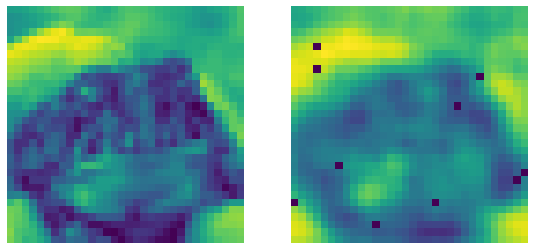

In [16]:
# Print some random images to verify the encoding and decoding.
plt.figure(figsize=(50,10))
plt.subplot(1, 10, 1) and plt.axis('off') and plt.imshow(x_train[25].reshape(32,32))
plt.subplot(1, 10, 2) and plt.axis('off') and plt.imshow(decoded_data[25].reshape(32,32))

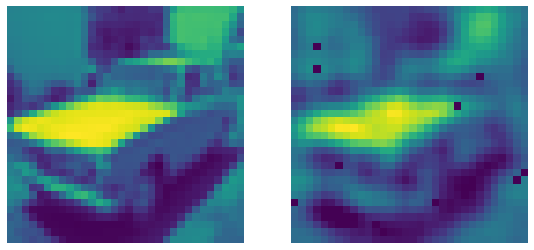

In [17]:
plt.figure(figsize=(50,10))
plt.subplot(1, 10, 1) and plt.axis('off') and plt.imshow(x_train[96].reshape(32,32))
plt.subplot(1, 10, 2) and plt.axis('off') and plt.imshow(decoded_data[96].reshape(32,32))

In [18]:
# KMeans clustering on the encoded data
km = KMeans(n_clusters=10, max_iter=100)

In [19]:
km.fit(encoded_data)

KMeans(max_iter=100, n_clusters=10)

In [20]:
 cluster_labels = km.fit_predict(encoded_data)
 print("Silhouette score of the cluster is : ", silhouette_score(encoded_data, cluster_labels))

Silhouette score of the cluster is :  0.045223407
